In [1]:
import sys
sys.path.append("..")

In [25]:
import importlib
import dccs
import dccs.math.camera_model
import dccs.math.algebra as dm
from dccs.math.extrinsic import Transformation
from dccs.math.algebra import quaternion_to_angles
importlib.reload(dccs.math.camera_model)
from dccs.math.camera_model import CameraData
#from dccs.math.odometry import SlamOdometry
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['savefig.dpi'] = 300
%matplotlib notebook

In [6]:
def load_logs_set(camera_data, suffix):
    full_logs = [f for f in camera_data.list_dir("logs") if f.startswith("full") and f.endswith(suffix)]
    assert len(full_logs) == 1
    full_log = full_logs[0]
    time = full_log[len("full_positions_log"):]
    pose_log = [f for f in camera_data.list_dir("logs") if f.startswith("positions") and f.endswith(time)][0]
    estimations_log = [f for f in camera_data.list_dir("logs") if f.startswith("estimations") and f.endswith(time)][0]
    return time, full_log, pose_log, estimations_log

In [7]:
working_dir = "/home/drv/pCloudDrive/magisterka/"
straight = CameraData("final_stereo/straight")
askew = CameraData("final_stereo/askew")

# Ground truth
In following example ground truth was based on printed camera rig paramters. They are following:

In [8]:
#true_rotation = np.array([0, -30, 45]) / 180 * np.pi
#true_translation = -np.array([48, 12,  0])
#true_translation = dm.rotation_angles_to_mtx(true_rotation).T.dot(np.array([12, 48, 0]))
#true_transformation = Transformation(rotation_mtx=dm.rotation_angles_to_mtx(true_rotation), latter_translation=true_translation)
#print(true_transformation)
#print(true_transformation.inverse())

true_rotation = np.array([0, -30, 45]) / 180.0 * np.pi
true_mtx = dm.rotation_angles_to_mtx(true_rotation).T
inv_translation = -(np.array([48, 12, 0]))
true_translation = true_mtx.T.dot(inv_translation)
inv_transformation = Transformation(rotation_mtx=true_mtx, latter_translation=true_translation)
true_transformation = inv_transformation.inverse()

print(true_transformation.norm)
print(inv_transformation.norm)
print(true_transformation.inverse().norm)

#Transformation{ shift:[-0.3249518  -0.90880655  0.26168107], rot:[ 0.0366837  -0.53609419  0.77037984], scale: 0.063935796687391} 
#<==>
#Transformation{ shift:[-0.96784031 -0.02281582 -0.25052857], rot:[-0.38558575  0.39399026 -0.84024877], scale: 0.05187470477777082} 


Transformation{ shift:[-0.94579746 -0.05677235  0.31975625], rot:[ 0.         -0.52359878  0.78539816], scale: 49.47726750741192}
Transformation{ shift:[-9.70142500e-01 -2.42535625e-01 -5.55111512e-17], rot:[-0.38759669  0.36136712 -0.85707195], scale: 49.47726750741192}
Transformation{ shift:[-9.70142500e-01 -2.42535625e-01 -5.55111512e-17], rot:[-0.38759669  0.36136712 -0.85707195], scale: 49.477267507411916}


In [9]:
print(true_mtx)
true_translation/dm.l2_norm(true_translation)

[[ 0.61237244  0.61237244  0.5       ]
 [-0.70710678  0.70710678  0.        ]
 [-0.35355339 -0.35355339  0.8660254 ]]


array([-0.42258994, -0.76558711, -0.48507125])

In [10]:
pos = ["x", "y", "z"]
ang = ["p", "q", "r"]
quat = ["qx", "qy", "qz", "qw"]
def v(pos):
    return ["v"+p for p in pos]
def e(pos):
    return ["e"+p for p in pos]
def r(pos):
    return ["r"+p for p in pos]
full_log_entry_len = 26

def quat_to_angle(row):
    q = quaternion_to_angles(np.array(row[quat])) # radians
    # q = q * 180 / np.pi # degrees
    row[r(ang)[0]] = q[0]
    row[r(ang)[1]] = q[1] 
    row[r(ang)[2]] = q[2]
    return row


def load_pose_log(camera_data, file_name):
    pose_entries = [l.strip().split(";") for l in camera_data.get_file("logs", file_name, "r").readlines()]
    parsed = []
    for entry in pose_entries:
        if entry[1].strip() != "None":
            parsed.append((entry[0], [float(i) for i in entry[1].split(",")],  float(entry[-1].strip())))
        else:
            parsed.append((entry[0], None, None))
    return parsed

def load_full_log(camera_data, file_name):
    log_array = np.frombuffer(camera_data.get_file("logs", file_name, "rb").read()).reshape((-1, full_log_entry_len))
    log_pd = pd.DataFrame(log_array, columns=['t'] + pos + v(pos) + ang + v(ang) + e(pos) + e(ang) + r(pos) + quat)
    return log_pd.apply(quat_to_angle, axis=1)

def load_est_log(camera_data, file_name):
    est_entries = [l.strip().split(";") for l in camera_data.get_file("logs", file_name).readlines()]
    parsed = []
    for entry in est_entries:
        t_arr = np.array([float(f) for f in entry[1].split(",")])
        if len(t_arr) == 6:
            t = Transformation.from_inlined(t_arr)
        elif len(t_arr) == 8:
            t = Transformation.from_inlined_full(t_arr)
        else:
            raise ValueError("Incorrect estimation: " + entry[1])
        parsed.append((entry[0], t))
    return parsed

In [11]:
sorted([x for x in straight.list_dir("logs") if x.startswith("full")])

['full_positions_log20190211_2320',
 'full_positions_log20190211_2324',
 'full_positions_log20190211_2326',
 'full_positions_log20190211_2328',
 'full_positions_log20190211_2336',
 'full_positions_log20190211_2342',
 'full_positions_log20190212_0005',
 'full_positions_log20190212_0008',
 'full_positions_log20190212_0013',
 'full_positions_log20190212_0020',
 'full_positions_log20190212_0039',
 'full_positions_log20190212_0043',
 'full_positions_log20190212_0049',
 'full_positions_log20190213_0529',
 'full_positions_log20190309_2122',
 'full_positions_log20190310_2354',
 'full_positions_log20190311_0124',
 'full_positions_log20190311_0228',
 'full_positions_log20190311_0251',
 'full_positions_log20190413_1912',
 'full_positions_log20190413_1919',
 'full_positions_log20190413_1931',
 'full_positions_log20190413_1934']

In [16]:
# 0013 - a LOT of captured poses, a lot of blocked time, low error,
# No poses: 0005,0008,0039,0043
#           2342            
# Weak ones: 2336
# 0020 - with slope syncs and good score
# 2328 - cool steps, multiple syncs on step
# 0529 - spiky & long, estimations not so great

suffix = "_2328"
time_s, full_s_file, pose_s_file, est_s_file = load_logs_set(straight, suffix)
time_a, full_a_file, pose_a_file, est_a_file = load_logs_set(askew, suffix)

assert time_s == time_a

print("Selected log from time " + time_s)
poses_s = load_pose_log(straight, pose_s_file)
poses_a = load_pose_log(askew, pose_a_file)

full_s = load_full_log(straight, full_s_file)
full_a = load_full_log(askew, full_a_file)

est_s = load_est_log(straight, est_s_file)
est_a = load_est_log(askew, est_a_file)

if len(est_s) == 0 or len(est_a) == 0:
    print("ERROR! No estimated poses!")

Selected log from time 20190211_2328


In [17]:
#detect gaps
def breaks_df(df, cols):
    gaps = df.t.diff(-1) < -1
    return pd.DataFrame({"t": df.t[gaps], "dt": -df.t.diff(-1)[gaps]})
    

gaps_a = (full_a.t.diff(1) > 1) #| (full_a.t.diff(-1) < -0.5)
gaps_s = (full_s.t.diff(1) > 1) #| (full_s.t.diff(-1) < -0.5)
aps_a = gaps_a.replace({False: None, True: 1.0})
gaps_s = gaps_s.replace({False: None, True: 1.0})
full_a["cont"] = gaps_a
full_s["cont"] = gaps_s
#events_a = full_a.t[gaps_a]
#events_s = full_s.t[gaps_s]

In [18]:
print("true:")

print(true_transformation.inverse().norm)
print("<==>")
print(true_transformation.norm, "\n")

print("estimations:")
for t, t2 in zip(est_s, est_a):
    print(t[1].norm, "\n<==>\n", t2[1].norm, "\n")
#[0, 48, 12]
#[25.45584413, 36.74234614, 21.21320344]
np.array([ 0.        , -0.52359878 ,          0.78539816]) * 180 / np.pi

true:
Transformation{ shift:[-9.70142500e-01 -2.42535625e-01 -5.55111512e-17], rot:[-0.38759669  0.36136712 -0.85707195], scale: 49.477267507411916}
<==>
Transformation{ shift:[-0.94579746 -0.05677235  0.31975625], rot:[ 0.         -0.52359878  0.78539816], scale: 49.47726750741192} 

estimations:
Transformation{ shift:[-0.36784405 -0.87611331 -0.31163476], rot:[ 0.06395177 -0.44099376  0.80371322], scale: 0.22414850168656994} 
<==>
 Transformation{ shift:[-0.02523116 -0.89235907 -0.45062032], rot:[-0.36801265  0.25627498 -0.86209432], scale: 0.10185572325094061} 

Transformation{ shift:[-0.34433044 -0.88619694 -0.30998635], rot:[ 0.05148881 -0.45342468  0.77835396], scale: 0.21386794536899245} 
<==>
 Transformation{ shift:[ 0.02917224 -0.87077129 -0.49082212], rot:[-0.36815104  0.28018178 -0.84600798], scale: 0.0997580743859147} 

Transformation{ shift:[-0.29606747 -0.89872693 -0.32347173], rot:[ 0.04835396 -0.44605352  0.77709537], scale: 0.2201481609126958} 
<==>
 Transformation{ sh

array([  0.        , -30.00000025,  44.99999981])

# Charts
## Position log with synchronization points (raw)

<IPython.core.display.Javascript object>


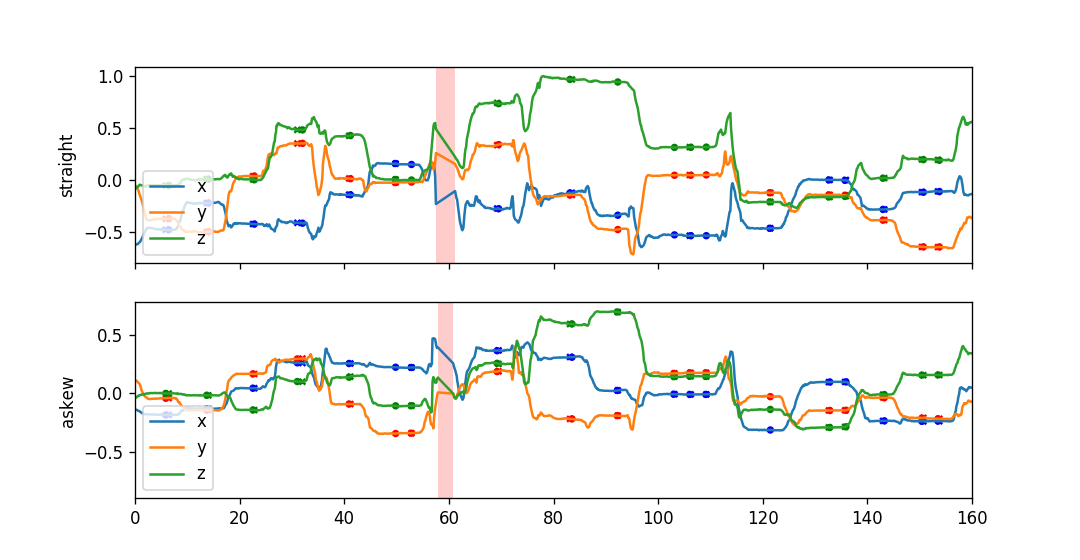

In [20]:
markersize=12
tshift = 1549924150
tlength = 160

def plot_msg_point(ax, point, t, marker):
    if t == None or point == None:
        return
    ax.scatter([t,t,t], point[:3], c=['b', 'r', 'g'], s=markersize, marker=marker)

def plot_breaks(ax, ts, dts):
    bottom, top = ax.get_ylim()
    ax.bar(ts, len(ts) * [top-bottom], bottom=len(ts)* [bottom], alpha=0.2,
           color='red', width=dts, align='edge')
    ax.set_ylim(bottom, top)



fig, (ax_straight, ax_askew) = plt.subplots(nrows=2, sharex=True)
for c in pos:
    ax_straight.plot(full_s["t"]-tshift, full_s["r"+c], label=c)
    ax_askew.plot(full_a["t"]-tshift, full_a["r"+c], label=c)
#ax_straight.barh([0] * len(events_a), events_a-events_a.min())#, alpha=0.2, color='red')
plot_max = full_a
breaks_a = breaks_df(full_a[["t"] + r(pos)], r(pos))
breaks_s = breaks_df(full_s[["t"] + r(pos)], r(pos))
plot_breaks(ax_askew, breaks_a.t-tshift, breaks_a.dt)
plot_breaks(ax_straight, breaks_s.t-tshift, breaks_s.dt)
ax_straight.set_xlim([0, tlength])
ax_straight.set(ylabel="straight")
ax_askew.set(ylabel="askew")

for entry in poses_a:
    if entry[0].endswith('straight') and entry[2] is not None:
        plot_msg_point(ax_straight, entry[1], entry[2]-tshift, "o")
    if entry[0].endswith('askew') and entry[2] is not None:
        plot_msg_point(ax_askew, entry[1], entry[2]-tshift, "x")
        
for entry in poses_s:
    if entry[0].endswith('askew') and entry[2] is not None:
        plot_msg_point(ax_askew, entry[1], entry[2]-tshift, "o")
    if entry[0].endswith('straight') and entry[2] is not None:
        plot_msg_point(ax_straight, entry[1], entry[2]-tshift, "x")
ax_straight.legend(loc="lower left")
ax_askew.legend(loc="lower left")
fig.savefig(working_dir+"stereo_full_pose.png")

## Orientation log with synchronization points

<IPython.core.display.Javascript object>


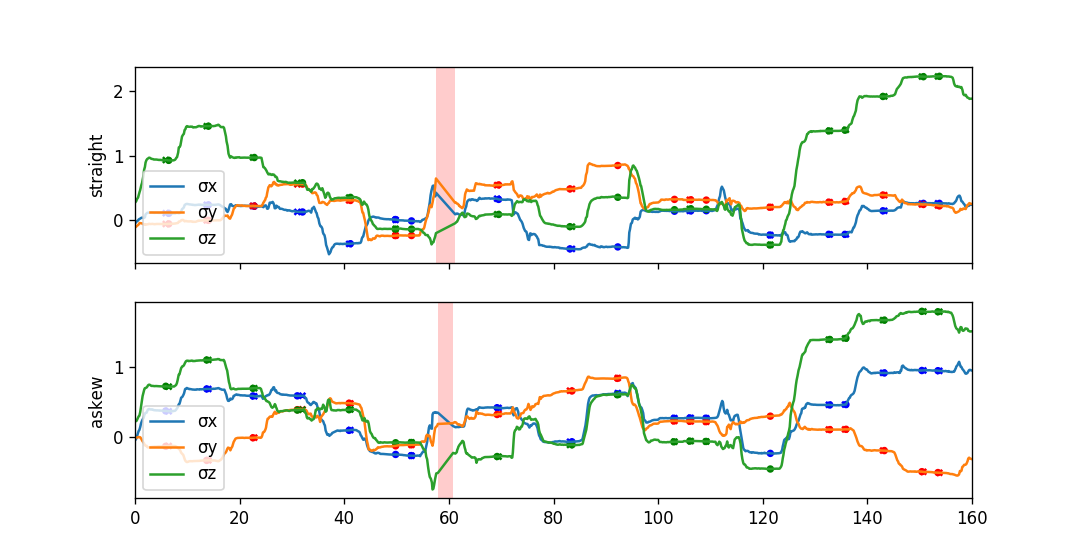

In [21]:
fig, (ax_straight, ax_askew) = plt.subplots(nrows=2, sharex=True)

def plot_orientation_point(ax, point, t, marker):
    if t == None or point == None:
        return
    ax.scatter([t,t,t], quaternion_to_angles(np.array(point[3:])), c=['b', 'r', 'g'], s=markersize, marker=marker)

for c,l in zip(ang,["x", "y", "z"]):
    ax_straight.plot(full_s["t"]-tshift, full_s["r"+c], label="σ"+l)
    ax_askew.plot(full_a["t"]-tshift, full_a["r"+c], label="σ"+l)
#ax_straight.plot(full_s["t"], full_s[r(ang)])
#ax_askew.plot(full_a["t"], full_a[r(ang)])

plot_breaks(ax_askew, breaks_a.t-tshift, breaks_a.dt)
plot_breaks(ax_straight, breaks_s.t-tshift, breaks_s.dt)
ax_straight.set_xlim([0, tlength])
ax_straight.set(ylabel="straight")
ax_askew.set(ylabel="askew")

for entry in poses_a:
    if entry[0].endswith('straight') and entry[2] is not None:
        plot_orientation_point(ax_straight, entry[1], entry[2]-tshift, "o")
    if entry[0].endswith('askew') and entry[2] is not None:
        plot_orientation_point(ax_askew, entry[1], entry[2]-tshift, "x")
        
for entry in poses_s:
    if entry[0].endswith('askew') and entry[2] is not None:
        plot_orientation_point(ax_askew,  entry[1], entry[2]-tshift, "o")
    if entry[0].endswith('straight') and entry[2] is not None:
        plot_orientation_point(ax_straight, entry[1], entry[2]-tshift, "x")
ax_straight.legend(loc="lower left")
ax_askew.legend(loc="lower left")
fig.savefig(working_dir+"stereo_full_orientation.png")

# Analyze result estimations

Result poses in est_ are describing tranformation between camera origins. Note, that recorded poses (full_ ) are registered in arbitrary odom frame, not in camera frame - so it cannot be simply mapped with discovered transformation. They have to be merged with some common point - here let it be first registered pose.

In [22]:
def find_first_poses_pair(poses):
    for poses_idx in range(0, len(poses), 2):
        p1 = poses[poses_idx]
        p2 = poses[poses_idx+1]
        if p1[1] != None and p2[1] != None:
            print(f"Selected idx {poses_idx}")
            return [Transformation.from_inlined_quaternion(np.array(x[1])) for x in poses[poses_idx:poses_idx+2]]
cpose_s, cpose_a = find_first_poses_pair(poses_a)
print(cpose_s)
print(cpose_a)

Selected idx 0
Transformation{ shift:[-0.58192739 -0.17812243 -0.17129022], rot:[-0.05238262 -0.12579439  0.2414066 ], scale: 1.0}
Transformation{ shift:[-0.15307376  0.0836776  -0.05158235], rot:[-0.07473897 -0.01327895  0.19731113], scale: 1.0}


Transformation{ shift:[ 0.00160437 -0.12993026 -0.02861946], rot:[-0.39184704  0.26936515 -0.85176729], scale: 0.7819888173604803}
Transformation{ shift:[ 0.48291804 -0.82935121  0.28101012], rot:[ 0.0019566   0.00096367 -0.02615365], scale: 1.0}


<IPython.core.display.Javascript object>


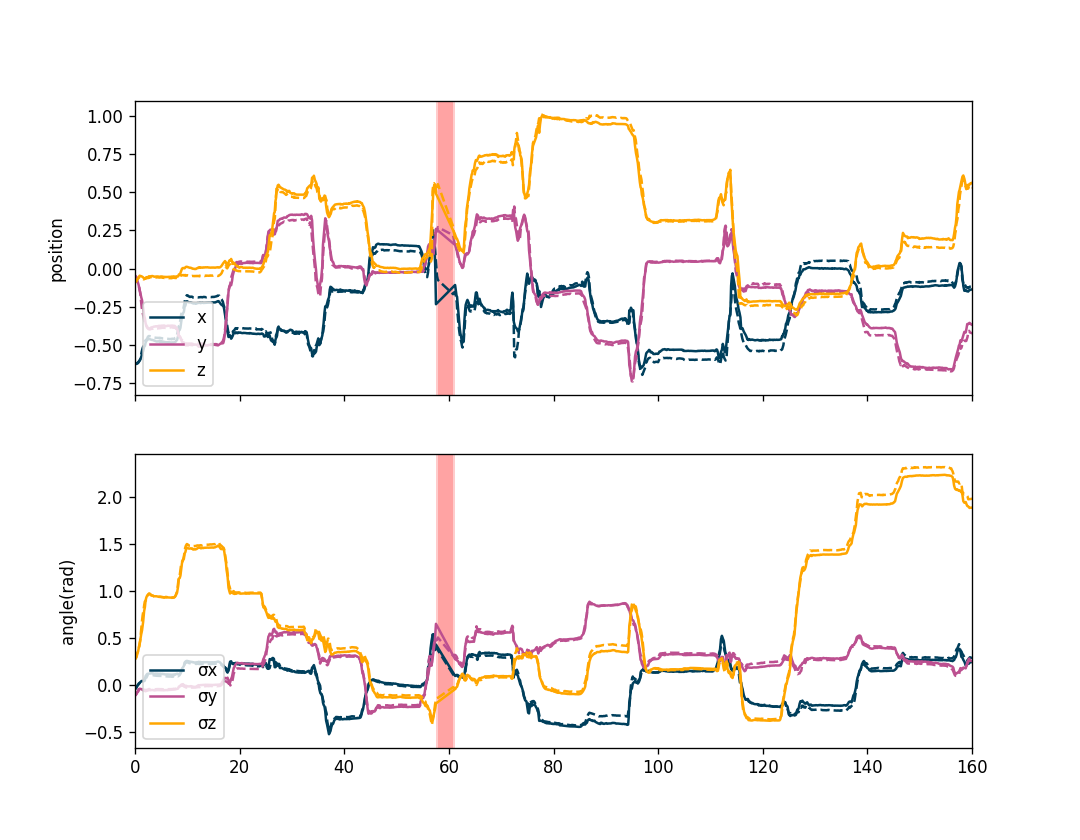

In [27]:
# plot raw data from camera stereo/askew and vision of this movement from another camera
t_a = est_a[-1][1]
print(t_a)
first_pose = Transformation.from_inlined(np.array(full_a[r(pos + ang)].iloc[0]))
print(first_pose)
def a2s(a_pose):
    return Transformation.from_inlined(a_pose).substract(cpose_a
                                                     ).around(t_a.inverse()).substract(cpose_s.inverse()).inline
log_s_from_a = full_a[r(pos + ang)].T.transform(a2s).T

fig, (ax_pos, ax_ang) = plt.subplots(nrows=2, sharex=True)
colors = ["#003f5c", "#bc5090","#ffa600"]

ax_ang.set_xlim([0, tlength])
for i,name in enumerate(["x", "y", "z"]):
    ax_ang.plot(full_s["t"]-tshift, full_s[r(ang)[i]], color=colors[i], label="σ"+name)
    ax_ang.plot(full_a["t"]-tshift, log_s_from_a[r(ang)[i]], "--", color=colors[i])

    ax_pos.plot(full_s["t"]-tshift, full_s[r(pos)[i]], color=colors[i], label=name)
    ax_pos.plot(full_a["t"]-tshift, log_s_from_a[r(pos)[i]], "--", color=colors[i])
    
plot_breaks(ax_pos, breaks_a.t-tshift, breaks_a.dt)
plot_breaks(ax_pos, breaks_s.t-tshift, breaks_s.dt)
plot_breaks(ax_ang, breaks_a.t-tshift, breaks_a.dt)
plot_breaks(ax_ang, breaks_s.t-tshift, breaks_s.dt)
ax_ang.set(ylabel="angle(rad)")
ax_pos.set(ylabel="position")
ax_pos.legend(loc="lower left")
ax_ang.legend(loc="lower left")
plt.plot()
fig.savefig(working_dir + "transformed_test_a2s.png")


Transformation{ shift:[-0.07484116 -0.12747025 -0.07612757], rot:[ 0.07043983 -0.4651156   0.76895926], scale: 1.2669687588917131}


<IPython.core.display.Javascript object>


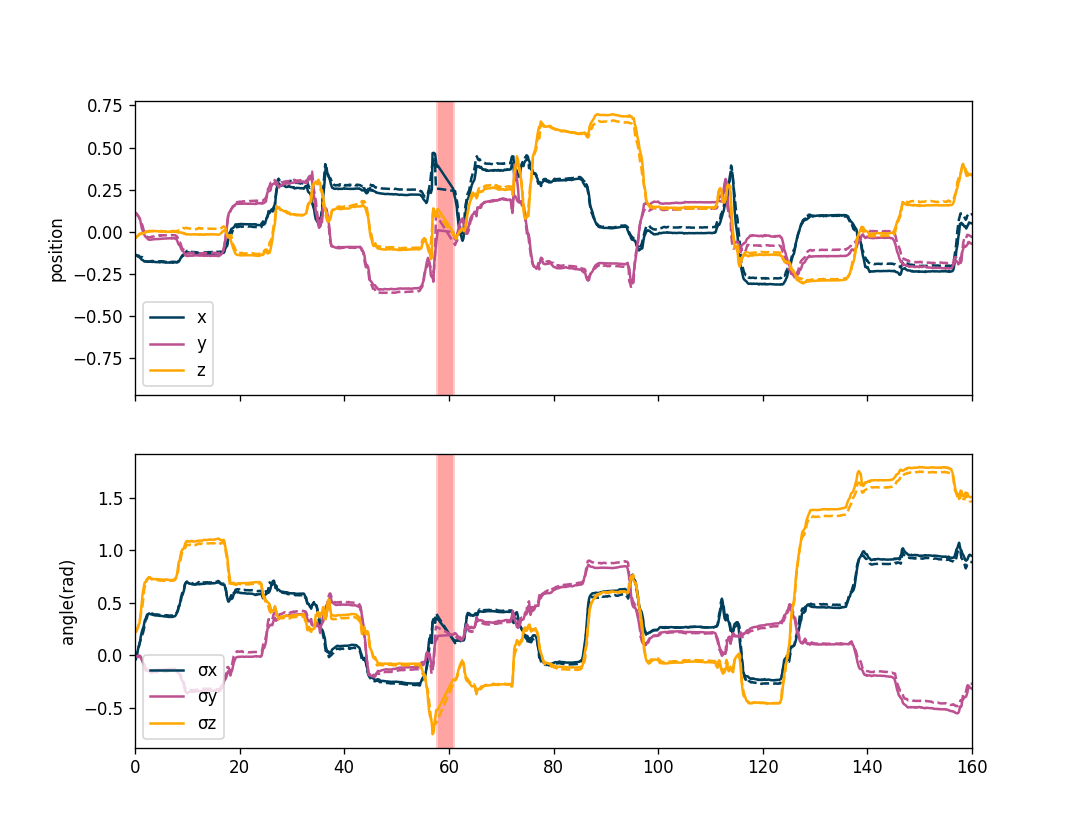

In [28]:
# plot raw data from camera stereo/askew and vision of this movement from another camera
t_s = est_s[-1][1]
#t_s.scale = 1.085
print(t_s)

def s2a(s_pose):
    return Transformation.from_inlined(s_pose).substract(cpose_s
                                                     ).around(t_s.inverse()).substract(cpose_a.inverse()).inline
    #return Transformation.from_inlined(s_pose).around(t_s.inverse()).inline
log_a_from_s = full_s[r(pos + ang)].T.transform(s2a).T

fig, (ax_pos, ax_ang) = plt.subplots(nrows=2, sharex=True)

ax_ang.set_xlim([0, tlength])
for i,name in enumerate(["x", "y", "z"]):
    ax_ang.plot(full_a["t"]-tshift, full_a[r(ang)[i]], color=colors[i], label="σ"+name)
    ax_ang.plot(full_s["t"]-tshift, log_a_from_s[r(ang)[i]], "--", color=colors[i])

    ax_pos.plot(full_a["t"]-tshift, full_a[r(pos)[i]], color=colors[i], label=name)
    ax_pos.plot(full_s["t"]-tshift, log_a_from_s[r(pos)[i]], "--", color=colors[i])
plot_breaks(ax_pos, breaks_a.t-tshift, breaks_a.dt)
plot_breaks(ax_pos, breaks_s.t-tshift, breaks_s.dt)
plot_breaks(ax_ang, breaks_a.t-tshift, breaks_a.dt)
plot_breaks(ax_ang, breaks_s.t-tshift, breaks_s.dt)

ax_ang.set(ylabel="angle(rad)")
ax_pos.set(ylabel="position")
ax_pos.legend(loc="lower left")
ax_ang.legend(loc="lower left")
plt.plot()
fig.savefig(working_dir + "transformed_test_s2a.png")

In [42]:
trimmed_s = pd.DataFrame(full_s[r(pos+ang)])
trimmed_a = pd.DataFrame(full_a[r(pos+ang)])
idx_a = pd.to_datetime(full_a["t"], unit='s')
idx_s = pd.to_datetime(full_s["t"], unit='s')

new_a = trimmed_a.set_index(idx_a)
new_s = trimmed_s.set_index(idx_s)
oidx_a = new_a.index
oidx_s = new_s.index
nidx_a = pd.date_range(oidx_a.min(), oidx_a.max(), freq='s').round('s')
nidx_s = pd.date_range(oidx_s.min(), oidx_s.max(), freq='s').round('s')

resampled_a = new_a.reindex(oidx_a.union(nidx_a)).interpolate('time').reindex(nidx_a)
resampled_s = new_s.reindex(oidx_s.union(nidx_s)).interpolate('time').reindex(nidx_s)
"""
new_straight_in_askew = pd.DataFrame(log_straight_in_askew[pos+ang]).set_index(pd.to_datetime(log_straight["t"], unit='s'))
oidx = new_straight_in_askew.index
nidx = pd.date_range(oidx.min(), oidx.max(), freq='s').round('s')
resampled_straight_in_askew = new_straight_in_askew.reindex(oidx.union(nidx)).interpolate().reindex(nidx)
"""
common_idx = resampled_a.index.intersection(resampled_s.index)


diff = resampled_a.reindex(common_idx) - resampled_s.reindex(common_idx).T.transform(s2a).T
#trimmed_s.plot()
#resampled_s.plot()

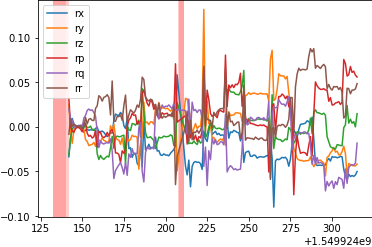

In [43]:
diff_timestamps = diff.index.astype(np.int64) // 10**9
#import itertools.
from itertools import chain

def isgood(val):
    for bt, bdt in chain(zip(breaks_s.t, breaks_s.dt), zip(breaks_a.t, breaks_a.dt)):
        if bt + bdt >= val:
            if bt <= val:
                return False
            else:
                break
    return True

diff_mask = [isgood(t) for t in diff_timestamps]
diff2 = diff[diff_mask]

fig, axs = plt.subplots()
axs.plot(diff_timestamps[diff_mask], diff2)
axs.legend(diff2)

# plt.plot(pd.to_datetime(breaks_a.t)))
plot_breaks(axs, breaks_s.t, breaks_s.dt)
plot_breaks(axs, breaks_a.t, breaks_a.dt)
#diff[pos].plot()
plt.show()
fig.savefig(working_dir + "stereo_error_plot.png")

In [44]:
diff2.describe() #abs(diff.describe()) -  abs(diff2.describe())

rx          ry          rz          rp          rq          rr
count  170.000000  170.000000  170.000000  170.000000  170.000000  170.000000
mean    -0.021244   -0.001190   -0.002752    0.012051   -0.013768    0.019143
std      0.020456    0.030589    0.018466    0.027129    0.029121    0.026864
min     -0.089900   -0.055013   -0.041304   -0.076056   -0.071757   -0.064651
25%     -0.035013   -0.021776   -0.014263   -0.005947   -0.040771    0.001418
50%     -0.024252   -0.004480   -0.004321    0.011516   -0.013427    0.013258
75%     -0.005058    0.019841    0.006301    0.029690    0.012641    0.035909
max      0.058295    0.131490    0.063124    0.080369    0.033965    0.087625

In [45]:
np.mean([est_row[1].scale * est_row2[1].scale for est_row,est_row2 in zip(est_a, est_s)])

0.9943433733350582

In [46]:
estimations_a = pd.DataFrame([est_row[1].norm.pure_inline for est_row in est_a], columns=pos + ang)
estimations_s = pd.DataFrame([est_row[1].norm.pure_inline for est_row in est_s], columns=pos + ang)
#estimations_a = estimations_a.join(pd.DataFrame(estimations_a.apply(lambda x: dm.l2_norm(x[pos]), axis=1), columns=["norm"]))

In [47]:
#fig = estimations_a.plot.box()
#fig.plot()
#estimations_s.plot.box()


[-0.42258994 -0.76558711 -0.48507125]
[-0.45406799  0.62863568  0.631379  ]


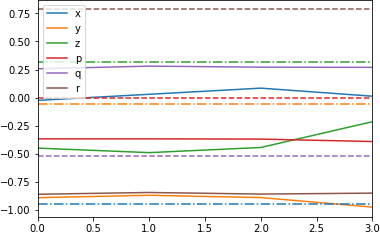

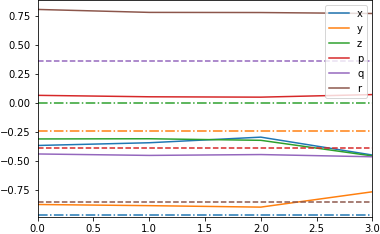

In [48]:
%matplotlib inline
est_a_plt = estimations_a.plot()
est_s_plt = estimations_s.plot()
print(true_transformation.inverse().norm.translation)
print(true_transformation.norm.translation)
for est_elem,c in zip(true_transformation.norm.pure_translation, ["C0", "C1", "C2"]):
    est_a_plt.axhline(est_elem, linestyle="-.", color=c)
for est_elem,c in zip(true_transformation.norm.angles, ["C3", "C4", "C5"]):
    est_a_plt.axhline(est_elem, linestyle="--", color=c)
for est_elem,c in zip(true_transformation.inverse().norm.pure_translation, ["C0", "C1", "C2"]):
    est_s_plt.axhline(est_elem, linestyle="-.", color=c)
for est_elem,c in zip(true_transformation.inverse().norm.angles, ["C3", "C4", "C5"]):
    est_s_plt.axhline(est_elem, linestyle="--", color=c)

In [49]:
print(true_transformation.inverse().norm)
estimations_s
np.array([0.070440, -0.465116, 0.768959]) * 180 / np.pi

Transformation{ shift:[-9.70142500e-01 -2.42535625e-01 -5.55111512e-17], rot:[-0.38759669  0.36136712 -0.85707195], scale: 49.477267507411916}


array([  4.03591471, -26.64918378,  44.05810532])

In [50]:
estimations_s.apply(lambda x: x-true_transformation.inverse().norm.pure_inline, axis=1)

x         y         z         p         q         r
0  0.602298 -0.633578 -0.311635  0.451548 -0.802361  1.660785
1  0.625812 -0.643661 -0.309986  0.439085 -0.814792  1.635426
2  0.674075 -0.656191 -0.323472  0.435951 -0.807421  1.634167
3  0.520021 -0.524117 -0.457859  0.458037 -0.826483  1.626031

In [51]:
import dccs.math.algebra as dm

def normalize_pos(row):
    row[pos] = dm.normalized_l2(row[pos])
    return row
    
normalized_estimations_a = estimations_a[pos].apply(normalize_pos, axis=1)
normalized_estimations_s = estimations_s[pos].apply(normalize_pos, axis=1)
print(dm.normalized_l2(true_translation))

[-0.42258994 -0.76558711 -0.48507125]


In [52]:
print(normalized_estimations_a)
print(normalized_estimations_s)

          x         y         z
0 -0.025231 -0.892359 -0.450620
1  0.029172 -0.870771 -0.490822
2  0.083868 -0.891635 -0.444920
3  0.012058 -0.976519 -0.215096
          x         y         z
0 -0.367844 -0.876113 -0.311635
1 -0.344330 -0.886197 -0.309986
2 -0.296067 -0.898727 -0.323472
3 -0.450122 -0.766652 -0.457859


In [53]:
diff.describe() # crazy36

rx          ry          rz          rp          rq          rr
count  183.000000  183.000000  183.000000  183.000000  183.000000  183.000000
mean    -0.033053    0.008467    0.013716    0.014083   -0.014284    0.022226
std      0.071918    0.074591    0.075317    0.028986    0.028834    0.028827
min     -0.555139   -0.069653   -0.041304   -0.076056   -0.073444   -0.064651
25%     -0.036720   -0.021430   -0.013422   -0.005808   -0.040528    0.001892
50%     -0.025910   -0.003086   -0.003225    0.012534   -0.016552    0.015322
75%     -0.005068    0.021031    0.008167    0.033658    0.011374    0.042574
max      0.132528    0.657717    0.512908    0.080369    0.033965    0.087625

In [54]:
dm.normalized_l2(np.array([25.45584413, 36.74234614, 21.21320344]))

array([0.51449576, 0.74261066, 0.42874646])

In [55]:
#Transformation([40, 10, 0], np.array([-np.pi/6, 0, np.pi/4])

In [56]:
diff.describe()

rx          ry          rz          rp          rq          rr
count  183.000000  183.000000  183.000000  183.000000  183.000000  183.000000
mean    -0.033053    0.008467    0.013716    0.014083   -0.014284    0.022226
std      0.071918    0.074591    0.075317    0.028986    0.028834    0.028827
min     -0.555139   -0.069653   -0.041304   -0.076056   -0.073444   -0.064651
25%     -0.036720   -0.021430   -0.013422   -0.005808   -0.040528    0.001892
50%     -0.025910   -0.003086   -0.003225    0.012534   -0.016552    0.015322
75%     -0.005068    0.021031    0.008167    0.033658    0.011374    0.042574
max      0.132528    0.657717    0.512908    0.080369    0.033965    0.087625

In [57]:
true_t = np.array([-0.4226, -0.7656, -0.4851])
dynamic_est = np.array([-0.4501, -0.7667, -0.4579])
static_est = np.array([-0.32706871, -0.83100504, -0.44995186])

In [37]:
np.arccos(true_t.dot(static_est)) * 180 / np.pi

6.923329486068644